In [1]:
import pandas as pd
from collections import defaultdict, Counter
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import csv
from adjustText import adjust_text
from matplotlib.ticker import FormatStrFormatter
from scipy import stats

In [2]:
ROOT = '/data0/lucy/language-map-of-science/'
LOGS = ROOT + 'logs/'
DATA = ROOT + 'data/'

In [3]:
sns.set(rc={"figure.dpi":300})
sns.set_style("whitegrid")

## Type jargon in FOS

In [4]:
def get_fos_type_jargonyness(fos_type_folder, cutoff=0.1): 
    fos_type_scores = defaultdict(list)
    fos_avg_type = Counter()
    fos_type_scores_word = defaultdict(float)
    fos_type_prop = Counter() # { fos : proportion of words with npmi > cutoff}
    for fos in os.listdir(fos_type_folder): 
        df = pd.read_csv(os.path.join(fos_type_folder, fos))
        fos_type_scores[fos] = df['pmi'].to_list()
        tups = list(zip(df.word, df.pmi))
        for tup in tups: 
            fos_type_scores_word[(fos, tup[0])] = tup[1] 
        pos_vals = [i for i in fos_type_scores[fos] if i > 0]
        if pos_vals: 
            fos_avg_type[fos] = sum(pos_vals) / len(fos_type_scores[fos])
        else: 
            fos_avg_type[fos] = 0
        prop = [1 for i in fos_type_scores[fos] if i > cutoff]
        fos_type_prop[fos] = len(prop) / len(fos_type_scores[fos])
    return fos_avg_type, fos_type_scores, fos_type_scores_word, fos_type_prop
    
def show_FOS_distributions(fos_of_interest, npmi_dict, xlim=(-0.6, 0.6), xlabel=""): 
    for i, fos in enumerate(fos_of_interest): 
        fig, axs = plt.subplots(figsize=(2, 2), dpi=200)
        plt.hist(npmi_dict[fos], density=True, bins=30)
        plt.xlim(xlim[0], xlim[1])
        plt.title(fos, fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.ylabel("Density", fontsize=15)
        if xlabel != '': 
            plt.xlabel(xlabel, fontsize=12)
        plt.setp(axs.patches, linewidth=0)
        plt.show()
        if i > 10: 
            break

In [5]:
fos_type_folder = LOGS + 'type_npmi/fos_set-False_lemma-True/'
fos_avg_type, fos_type_scores, fos_type_scores_word, fos_type_prop = get_fos_type_jargonyness(fos_type_folder)

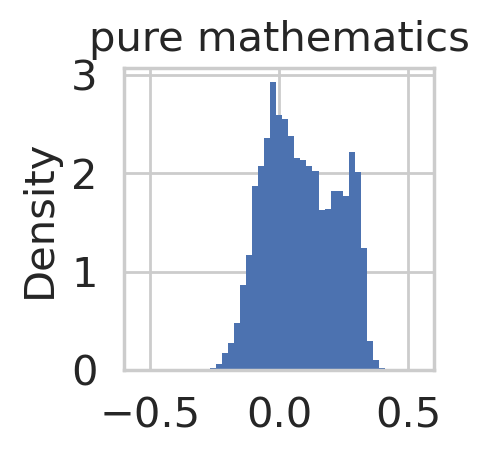

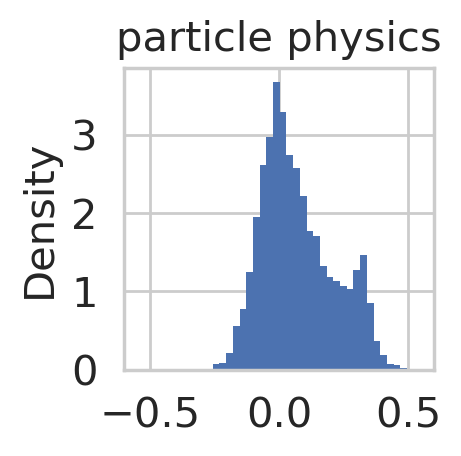

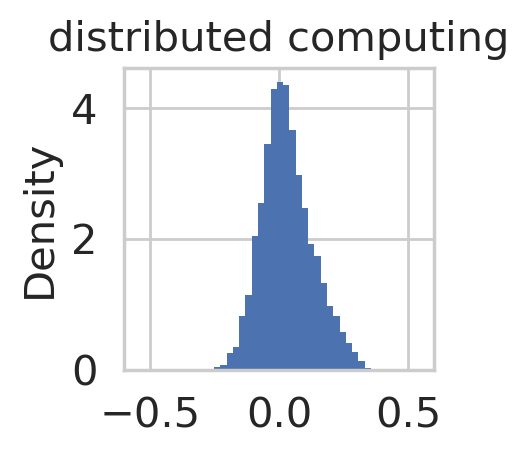

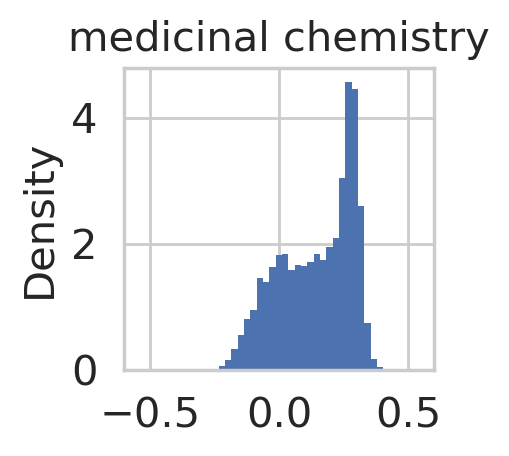

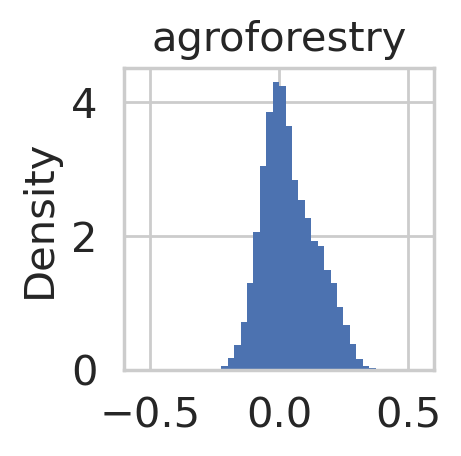

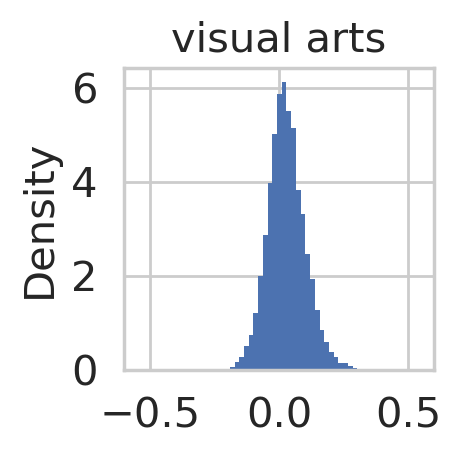

In [6]:
show_FOS_distributions(['pure mathematics', 'particle physics', 'distributed computing', 
                       'medicinal chemistry', 'agroforestry', 'visual arts'], fos_type_scores)

In [7]:
print(fos_avg_type.most_common())

[('medicinal chemistry', 0.15815832289742318), ('geochemistry', 0.1136092173130143), ('polymer chemistry', 0.11320713422380553), ('stereochemistry', 0.11273164634564913), ('combinatorial chemistry', 0.11189904787989062), ('cancer research', 0.11086772146291173), ('organic chemistry', 0.11071119454653601), ('photochemistry', 0.1100957875130397), ('pure mathematics', 0.10999428840684455), ('paleontology', 0.10762678772362641), ('cell biology', 0.10708626512037178), ('zoology', 0.10487303127245222), ('molecular biology', 0.10470206053923213), ('botany', 0.10206038978992968), ('traditional medicine', 0.10172183312566262), ('microbiology', 0.10021998616788347), ('crystallography', 0.09874482410561713), ('mathematical physics', 0.09814496653504184), ('physical chemistry', 0.09793018191505791), ('virology', 0.09773460500013527), ('horticulture', 0.0976863975080906), ('biochemistry', 0.09750667362935378), ('inorganic chemistry', 0.09717297206606336), ('pharmacology', 0.09697420179561088), ('pa

In [8]:
level_to_topics = defaultdict(set)
with open(DATA + 'fos_level.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: 
        level_to_topics[row['level']].add(row['displayname'].lower())
level_to_children = defaultdict(set)
with open(DATA + 'mag_parent_child.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: 
        if row['parent_display_name'].lower() in level_to_topics['0']: 
            if row['child_display_name'].lower() in level_to_topics['1']: 
                level_to_children[row['parent_display_name'].lower()].add(row['child_display_name'].lower())

In [9]:
stem_mapping = {
    'history': 'non-STEM', 
    'geology': 'STEM', 
    'economics': 'STEM', 
    'geography': 'non-STEM', 
    'chemistry': 'STEM', 
    'philosophy': 'non-STEM',
    'sociology': 'non-STEM',
    'materials science': 'STEM', 
    'mathematics': 'STEM', 
    'biology': 'STEM', 
    'computer science': 'STEM', 
    'political science': 'non-STEM',
    'engineering': 'STEM', 
    'psychology': 'STEM', 
    'environmental science': 'STEM', 
    'business': 'non-STEM',
    'physics': 'STEM', 
    'art': 'non-STEM',
    'medicine': 'STEM', 
}
field_mapping = {
    'history': 'arts & humanities', 
    'geology': 'natural sciences', 
    'economics': 'social sciences', 
    'geography': 'natural sciences', 
    'chemistry': 'natural sciences', 
    'philosophy': 'arts & humanities',
    'sociology': 'social sciences',
    'materials science': 'natural sciences', 
    'mathematics': 'math & technology', 
    'biology': 'natural sciences', 
    'computer science': 'math & technology', 
    'political science': 'social sciences',
    'engineering': 'math & technology', 
    'psychology': 'social sciences', 
    'environmental science': 'natural sciences', 
    'business': 'social sciences',
    'physics': 'natural sciences', 
    'art': 'arts & humanities',
    'medicine': 'natural sciences', 
}

In [10]:
def plot_type_jargonyness(fos_avg_type, fos_type_prop, title_prefix): 
    d = {
        'top level FOS': [],
        'current FOS': [], 
        'score': [],
        'prop': [],
        'type of FOS': [],
    }

    top_level_scores = defaultdict(list)
    for parent in level_to_children: 
        children = level_to_children[parent]
        children.add('OTHER ' + parent)
        for child in children: 
            if child in fos_avg_type: 
                d['top level FOS'].append(parent)
                d['current FOS'].append(child)
                d['score'].append(fos_avg_type[child])
                d['type of FOS'].append(field_mapping[parent])
                d['prop'].append(fos_type_prop[child])
                top_level_scores[parent].append(fos_avg_type[child])

    top_level_avg = Counter()
    for parent in top_level_scores: 
        top_level_avg[parent] = np.mean(top_level_scores[parent])
    order = []
    for tup in top_level_avg.most_common(): 
        order.append(tup[0])

    FOS_type_df = pd.DataFrame.from_dict(d)

    sns.stripplot(data=FOS_type_df, x="score", y='top level FOS', hue='type of FOS', order=order)
    plt.xlabel("Average adjusted NPMI")
    plt.xlim(0, 0.2)
    plt.title(title_prefix + " How " + r"$\bf{type}$" + " jargony is each level 1 FOS?")
    plt.legend(loc="lower right")
    plt.show()
    
    sns.stripplot(data=FOS_type_df, x="prop", y='top level FOS', hue='type of FOS', order=order)
    plt.xlabel("Proportion of words w/ type NPMI > 0.1")
    plt.title(title_prefix + " How " + r"$\bf{type}$" + " jargony is each level 1 FOS?")
    plt.legend(loc="lower right")
    plt.show()

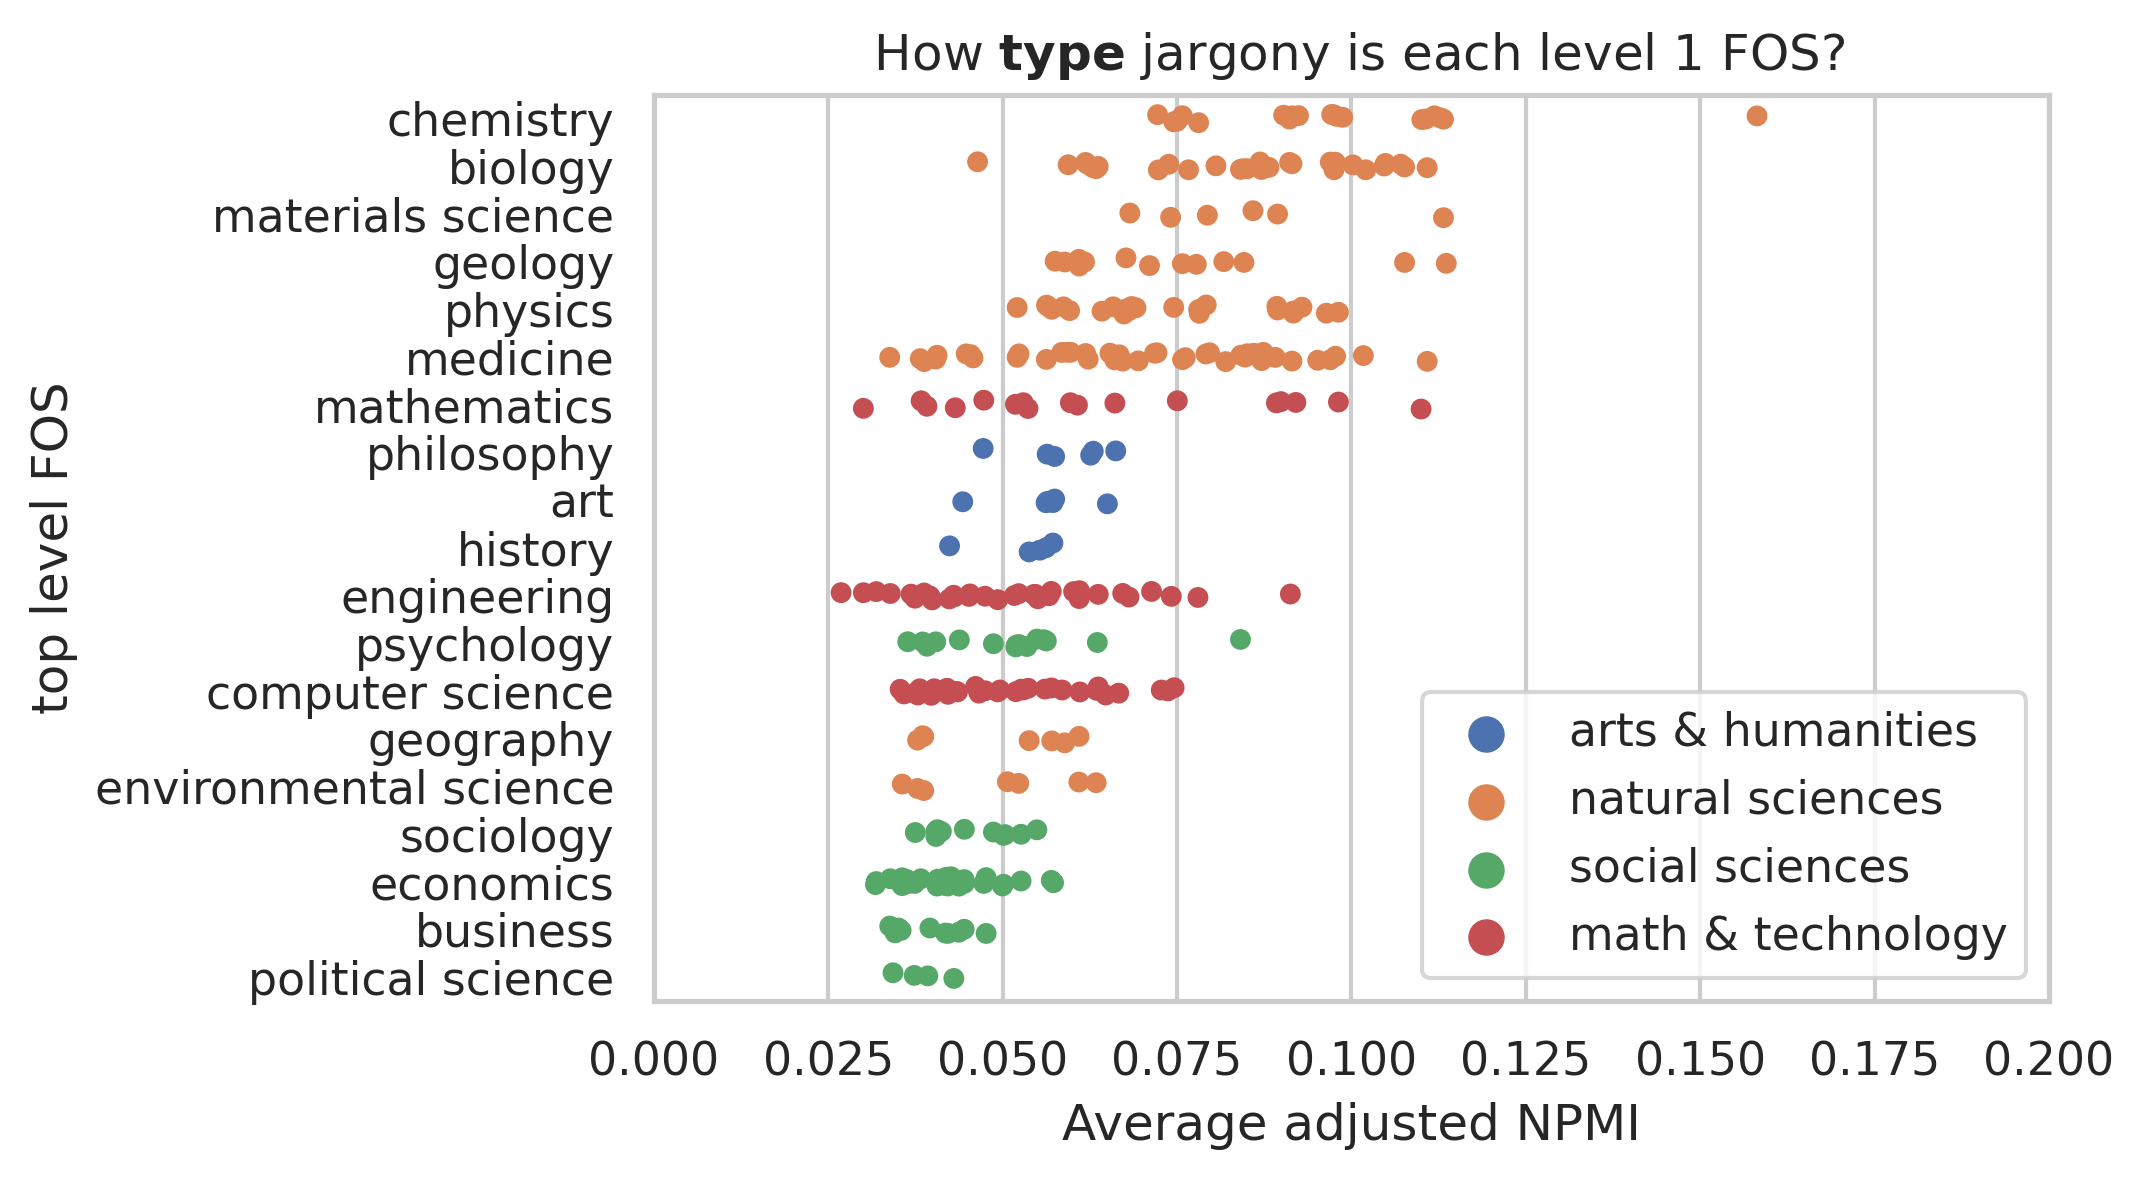

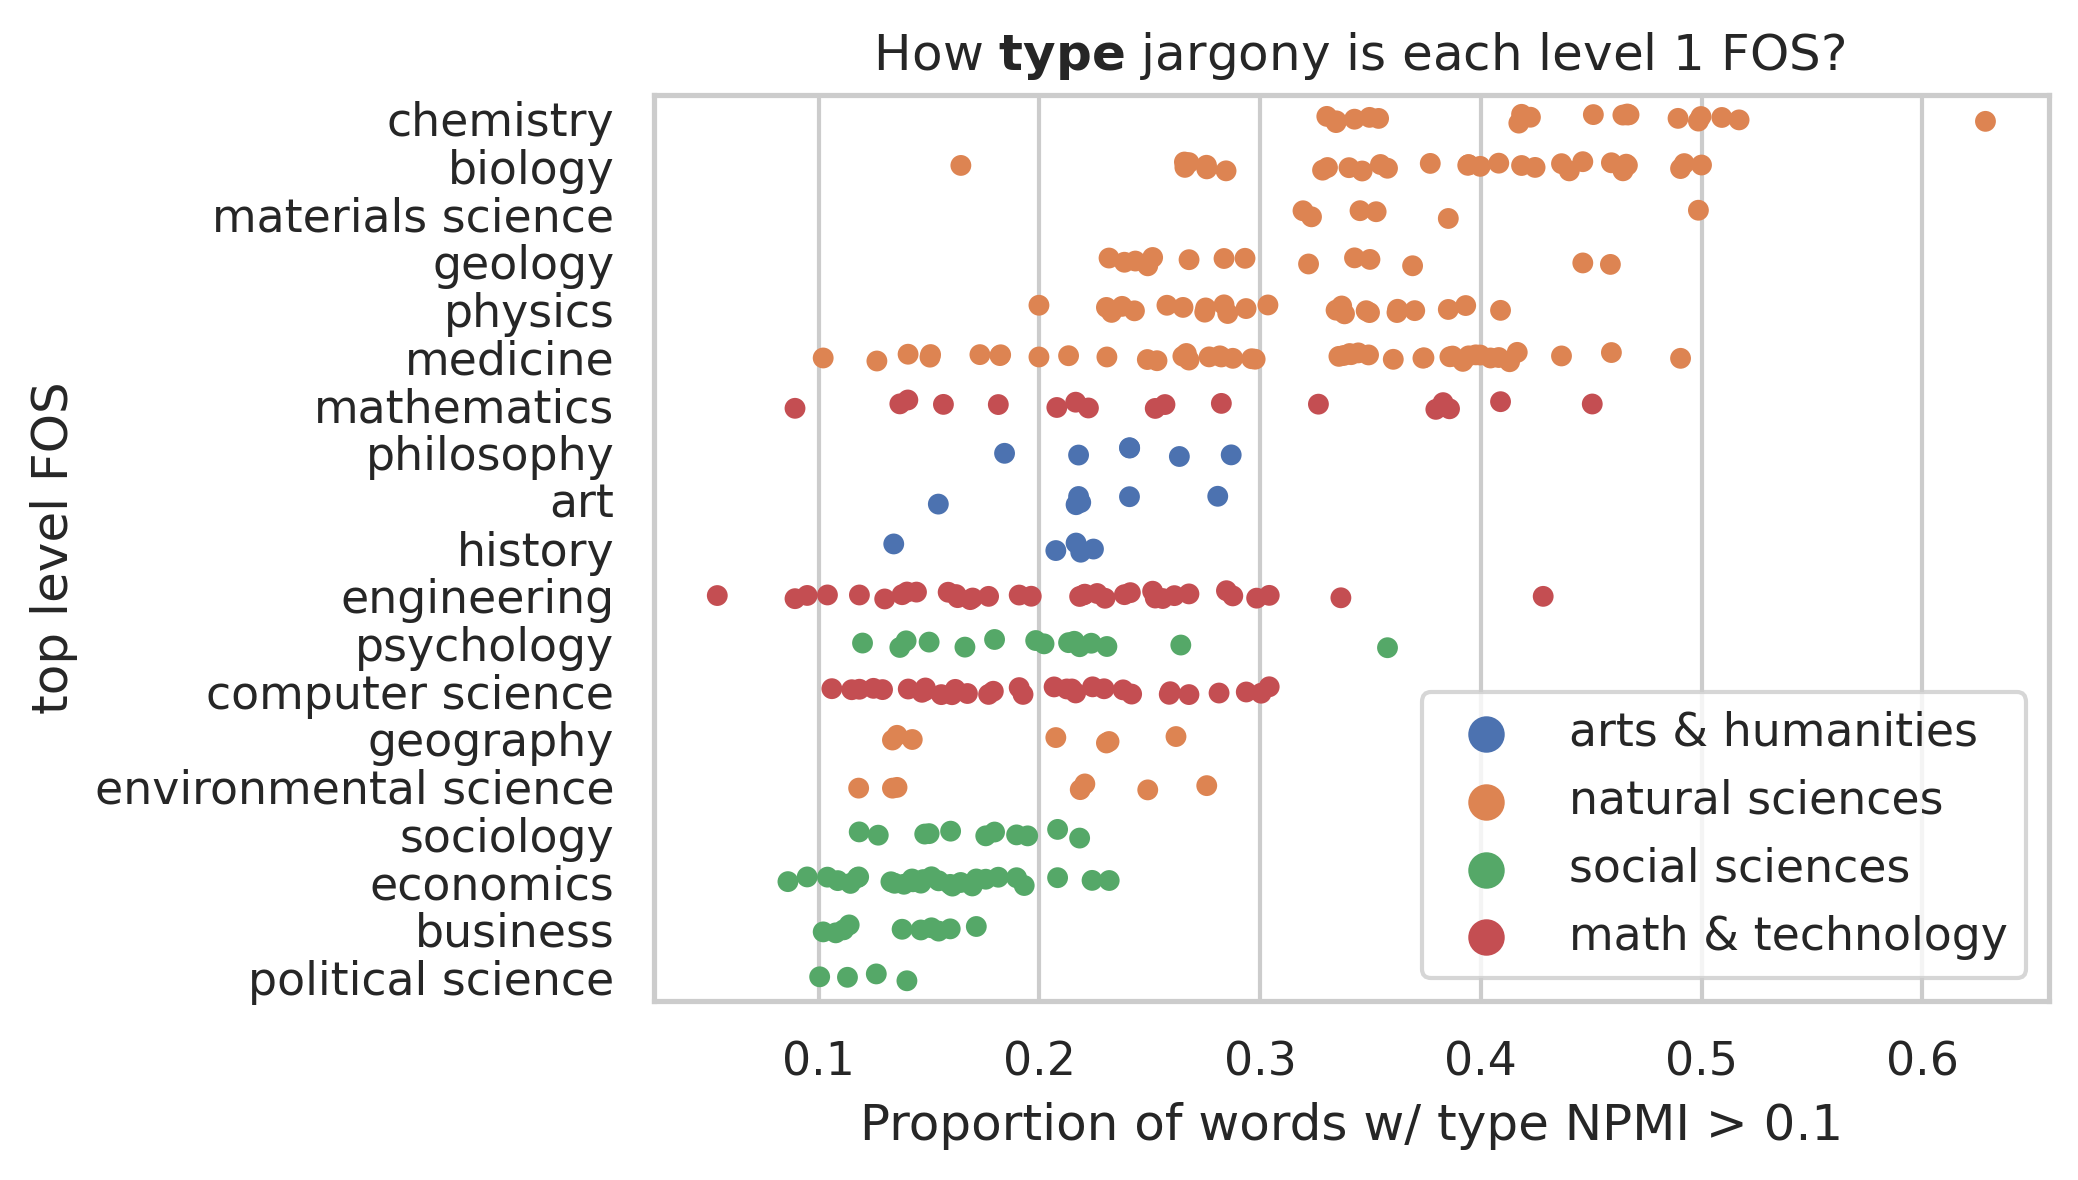

In [114]:
plot_type_jargonyness(fos_avg_type, fos_type_prop, "")

## Sense jargon in FOS

In [11]:
fos_sense_file = LOGS + 'fos_senses/es-True_res-0.0/ALL_scores.parquet'
fos_sense_df = pd.read_parquet(fos_sense_file)
fos_sense_df = fos_sense_df[fos_sense_df['count'] > 20]
fos_sense_df[['word', 'sense']] = fos_sense_df['word_sense'].str.split('_', expand=True)

In [50]:
this_fos_sense_df = fos_sense_df[fos_sense_df['fos'] == 'stereochemistry']
this_fos_sense_df.nlargest(10, 'npmi')

,fos,word_sense,npmi,count,word,sense
8426347,stereochemistry,compound_6,0.334776,8746,compound,6
8426499,stereochemistry,derivative_0,0.321940,11911,derivative,0
8426626,stereochemistry,ring_0,0.318224,6163,ring,0
8428375,stereochemistry,residue_0,0.309786,1660,residue,0
8426360,stereochemistry,complex_1,0.308148,27191,complex,1
8427639,stereochemistry,cis_0,0.300862,3312,cis,0
8431379,stereochemistry,pocket_1,0.300823,1100,pocket,1
8426417,stereochemistry,synthesis_0,0.286553,11289,synthesis,0
8430656,stereochemistry,ic_1,0.284457,537,ic,1
8427415,stereochemistry,coordination_0,0.280143,4696,coordination,0


In [13]:
fos_type_df = pd.read_csv(os.path.join(fos_type_folder, 'natural language processing'))
fos_type_df[fos_type_df['word'] == 'segmentation']
#fos_type_df.nlargest(10, 'pmi')

,word,pmi,count
7192,segmentation,0.229365,3932


In [14]:
def aggregate_by_most(fos_sense_df): 
    idx = fos_sense_df.groupby(['fos', 'word'])['count'].transform(max) == fos_sense_df['count']
    most_fos_sense_df = fos_sense_df[idx][['fos', 'word', 'npmi']]
    most_fos_sense_df = most_fos_sense_df.groupby(['fos', 'word'], sort=False)['npmi'].mean().to_dict()
    return most_fos_sense_df
def get_fos_sense_jargonyness(sense_df, fos_type_scores_word, cutoff=0.1): 
    fos_sense_scores = defaultdict(list)
    fos_avg_sense = Counter()
    fos_sense_prop = Counter()
    fos_vocab_total = Counter()
    for tup in sense_df: 
        fos_sense_scores[tup[0]].append(sense_df[tup])
        # count the word if it wouldn't have been included as a word type but 
        # is included as a word sense
        type_npmi = fos_type_scores_word[tup]
        if type_npmi <= cutoff and sense_df[tup] > cutoff: 
            fos_sense_prop[tup[0]] += 1
    for tup in fos_type_scores_word: 
        fos_vocab_total[tup[0]] += 1
    for fos in fos_sense_scores: 
        pos_vals = [i for i in fos_sense_scores[fos] if i > 0]
        if pos_vals: 
            fos_avg_sense[fos] = sum(pos_vals) / len(fos_sense_scores[fos])
        else: 
            fos_avg_sense[fos] = 0
        fos_sense_prop[fos] = fos_sense_prop[fos] / fos_vocab_total[fos]
    return fos_avg_sense, fos_sense_scores, fos_sense_prop

In [15]:
most_fos_sense_df = aggregate_by_most(fos_sense_df)

In [16]:
most_fos_avg_sense, most_fos_sense_scores, most_fos_sense_prop = get_fos_sense_jargonyness(most_fos_sense_df, fos_type_scores_word)

In [17]:
for tup in most_fos_sense_df: 
    if tup not in fos_type_scores_word: 
        print(tup)

In [18]:
most_fos_sense_df

{('radiology', 'patient'): 0.24775859007124226,
 ('radiology', 'image'): 0.28437020764217197,
 ('radiology', 'case'): 0.2602478483008104,
 ('radiology', 'ct'): 0.34680960902731056,
 ('radiology', 'use'): 0.021747230911275412,
 ('radiology', 'result'): 0.010639528315911447,
 ('radiology', 'study'): 0.06095748660098734,
 ('radiology', 'method'): 0.01651357704764428,
 ('radiology', 'diagnosis'): 0.26249434688259315,
 ('radiology', 'treatment'): 0.16402647832298425,
 ('radiology', 'clinical'): 0.18095664238578463,
 ('radiology', 'year'): 0.0699695335681637,
 ('radiology', 'cancer'): 0.1925106097373246,
 ('radiology', 'conclusion'): 0.16507546134918646,
 ('radiology', 'disease'): 0.15017114106979967,
 ('radiology', 'high'): 0.0037231764090168624,
 ('radiology', 'perform'): 0.14700173544432849,
 ('radiology', 'report'): 0.15273588111184058,
 ('radiology', 'show'): 0.032690634172825986,
 ('radiology', 'p'): 0.09565384287329134,
 ('radiology', 'group'): 0.03864757853910158,
 ('radiology', 'val

## What FOS gain the most when we include word senses? 

In [19]:
def get_combined_type_and_sense(type_scores, sense_scores): 
    '''
    type_scores: {(FOS, word): score}
    sense_scores: {(FOS, word): score}
    '''
    combined_scores = defaultdict(list) # {FOS: [scores]}
    type_sense_diff = defaultdict(Counter) # {FOS: {word: sense - type diff}}
    for tup in type_scores: 
        if tup not in sense_scores: 
            combined_scores[tup[0]].append(type_scores[tup])
        elif sense_scores[tup] > type_scores[tup]:
            # use sense score 
            combined_scores[tup[0]].append(sense_scores[tup])
        else: 
            combined_scores[tup[0]].append(type_scores[tup])
        if tup in sense_scores and sense_scores[tup] > 0: 
            type_sense_diff[tup[0]][tup[1]] = sense_scores[tup] - type_scores[tup]
    combined_scores_avg = Counter()
    for fos in combined_scores: 
        pos_vals = [i for i in combined_scores[fos] if i > 0]
        if pos_vals: 
            combined_scores_avg[fos] = sum(pos_vals) / len(combined_scores[fos])
        else: 
            combined_scores_avg[fos] = 0
    return combined_scores_avg, combined_scores, type_sense_diff

In [20]:
combined_scores_avg, combined_scores, type_sense_diff = get_combined_type_and_sense(fos_type_scores_word, most_fos_sense_df)
d = {
    'FOS': [], 
    'combined': [], 
    'type only': [], 
    'difference': [],
}
for fos in fos_avg_type:
    if fos == 'background': continue
    d['FOS'].append(fos)
    d['combined'].append(combined_scores_avg[fos])
    d['type only'].append(fos_avg_type[fos])
    d['difference'].append(combined_scores_avg[fos] - fos_avg_type[fos])
compare_jargonyness_df = pd.DataFrame.from_dict(d)

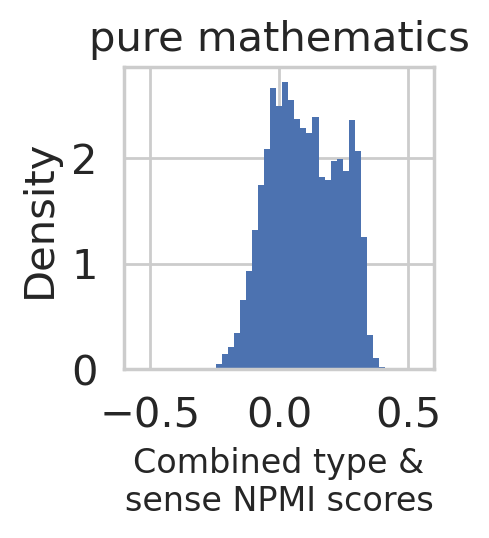

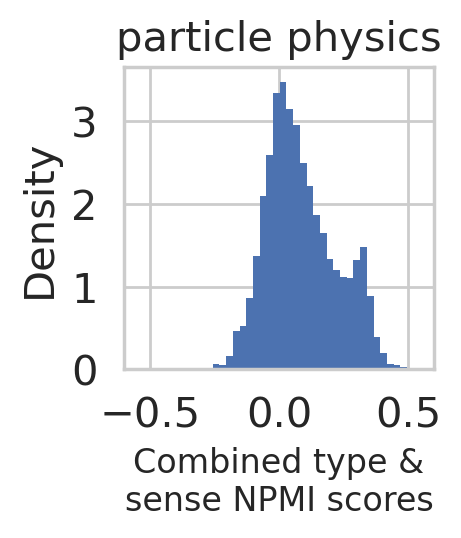

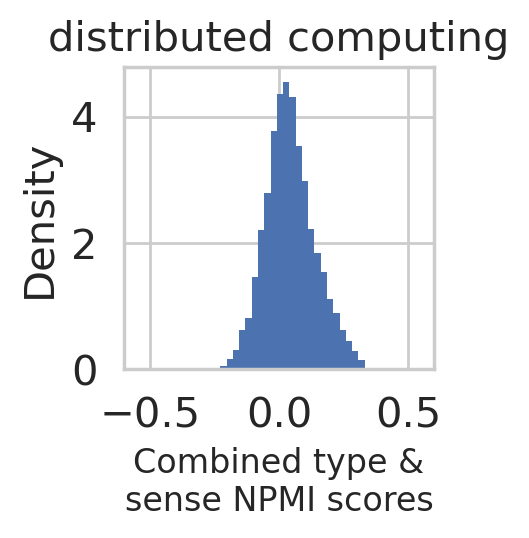

In [59]:
show_FOS_distributions(['pure mathematics', 'particle physics', 'distributed computing'], 
                       combined_scores, xlabel="Combined type &\nsense NPMI scores")

In [21]:
def plot_sense_jargonyness(type_sense_diff_agg, fos_sense_prop): 
    d = {
        'top level FOS': [],
        'current FOS': [], 
        'score': [],
        'prop': [],
        'type of FOS': [],
    }

    top_level_scores = defaultdict(list)
    for parent in level_to_children: 
        children = level_to_children[parent]
        children.add('OTHER ' + parent)
        for child in children: 
            if child in type_sense_diff_agg: 
                d['top level FOS'].append(parent)
                d['current FOS'].append(child)
                d['score'].append(type_sense_diff_agg[child])
                d['type of FOS'].append(field_mapping[parent])
                d['prop'].append(fos_sense_prop[child])
                top_level_scores[parent].append(type_sense_diff_agg[child])

    top_level_avg = Counter()
    for parent in top_level_scores: 
        top_level_avg[parent] = np.mean(top_level_scores[parent])
    order = []
    for tup in top_level_avg.most_common(): 
        order.append(tup[0])

    FOS_type_df = pd.DataFrame.from_dict(d)

    sns.stripplot(data=FOS_type_df, x="score", y='top level FOS', hue='type of FOS', order=order)
    plt.xlabel("Increase in average adjusted NPMI")
    plt.xlim(0, 0.01)
    plt.title(" How " + r"$\bf{sense}$" + " jargony is each level 1 FOS?")
    plt.legend(loc="lower right")
    plt.show()
    
    sns.stripplot(data=FOS_type_df, x="prop", y='top level FOS', hue='type of FOS', order=order)
    plt.xlabel("Proportion of words whose type NPMI <= 0.1 but sense NPMI > 0.1")
    plt.title(" How " + r"$\bf{sense}$" + " jargony is each level 1 FOS?")
    plt.legend(loc="lower right")
    plt.show()

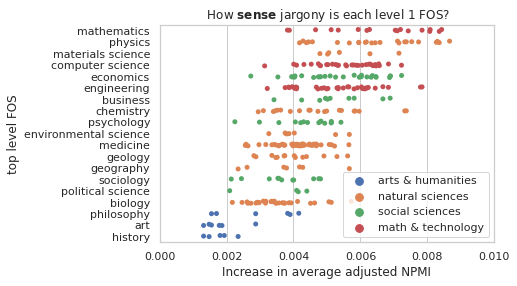

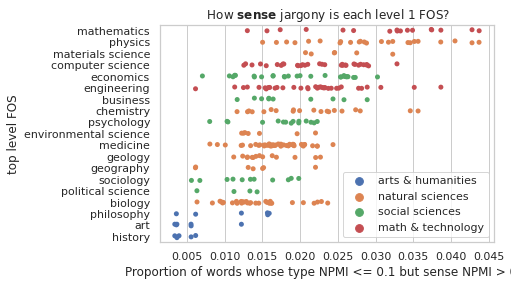

,combined,type only,difference
FOS,,,
computational physics,0.070392,0.064246,0.006146
embedded system,0.069880,0.063707,0.006173
optics,0.075295,0.069119,0.006176
structural engineering,0.067196,0.061008,0.006188
econometrics,0.053492,0.047299,0.006193
manufacturing engineering,0.051552,0.045317,0.006235
real-time computing,0.058162,0.051904,0.006258
topology,0.065984,0.059715,0.006269
nanotechnology,0.080372,0.074088,0.006284


In [48]:
df = compare_jargonyness_df.set_index("FOS").sort_values("difference")
type_sense_diff_agg = df['difference'].to_dict()
plot_sense_jargonyness(type_sense_diff_agg, most_fos_sense_prop)
df.tail(50)

In [52]:
fos = 'stereochemistry'
print('word diff type sense')
for tup in type_sense_diff[fos].most_common(20): 
    word = tup[0]
    key = (fos, word)
    if most_fos_sense_df[key] > 0.1: 
        print(word, round(type_sense_diff[fos][word], 3), 
          round(fos_type_scores_word[key], 3), 
          round(most_fos_sense_df[key], 3))

word diff type sense
attack 0.228 -0.044 0.184
title 0.216 0.048 0.264
km 0.212 -0.037 0.175
framework 0.205 0.01 0.215
solve 0.202 -0.037 0.165
group 0.186 0.063 0.25
reflection 0.178 -0.007 0.17
position 0.175 0.09 0.265
accept 0.173 -0.045 0.128
line 0.17 0.014 0.185
panel 0.17 -0.018 0.152
meta 0.17 0.031 0.2
displacement 0.167 0.033 0.201
auxiliary 0.166 0.061 0.227
competition 0.162 -0.058 0.105
treatment 0.162 -0.039 0.123
identity 0.162 -0.039 0.123


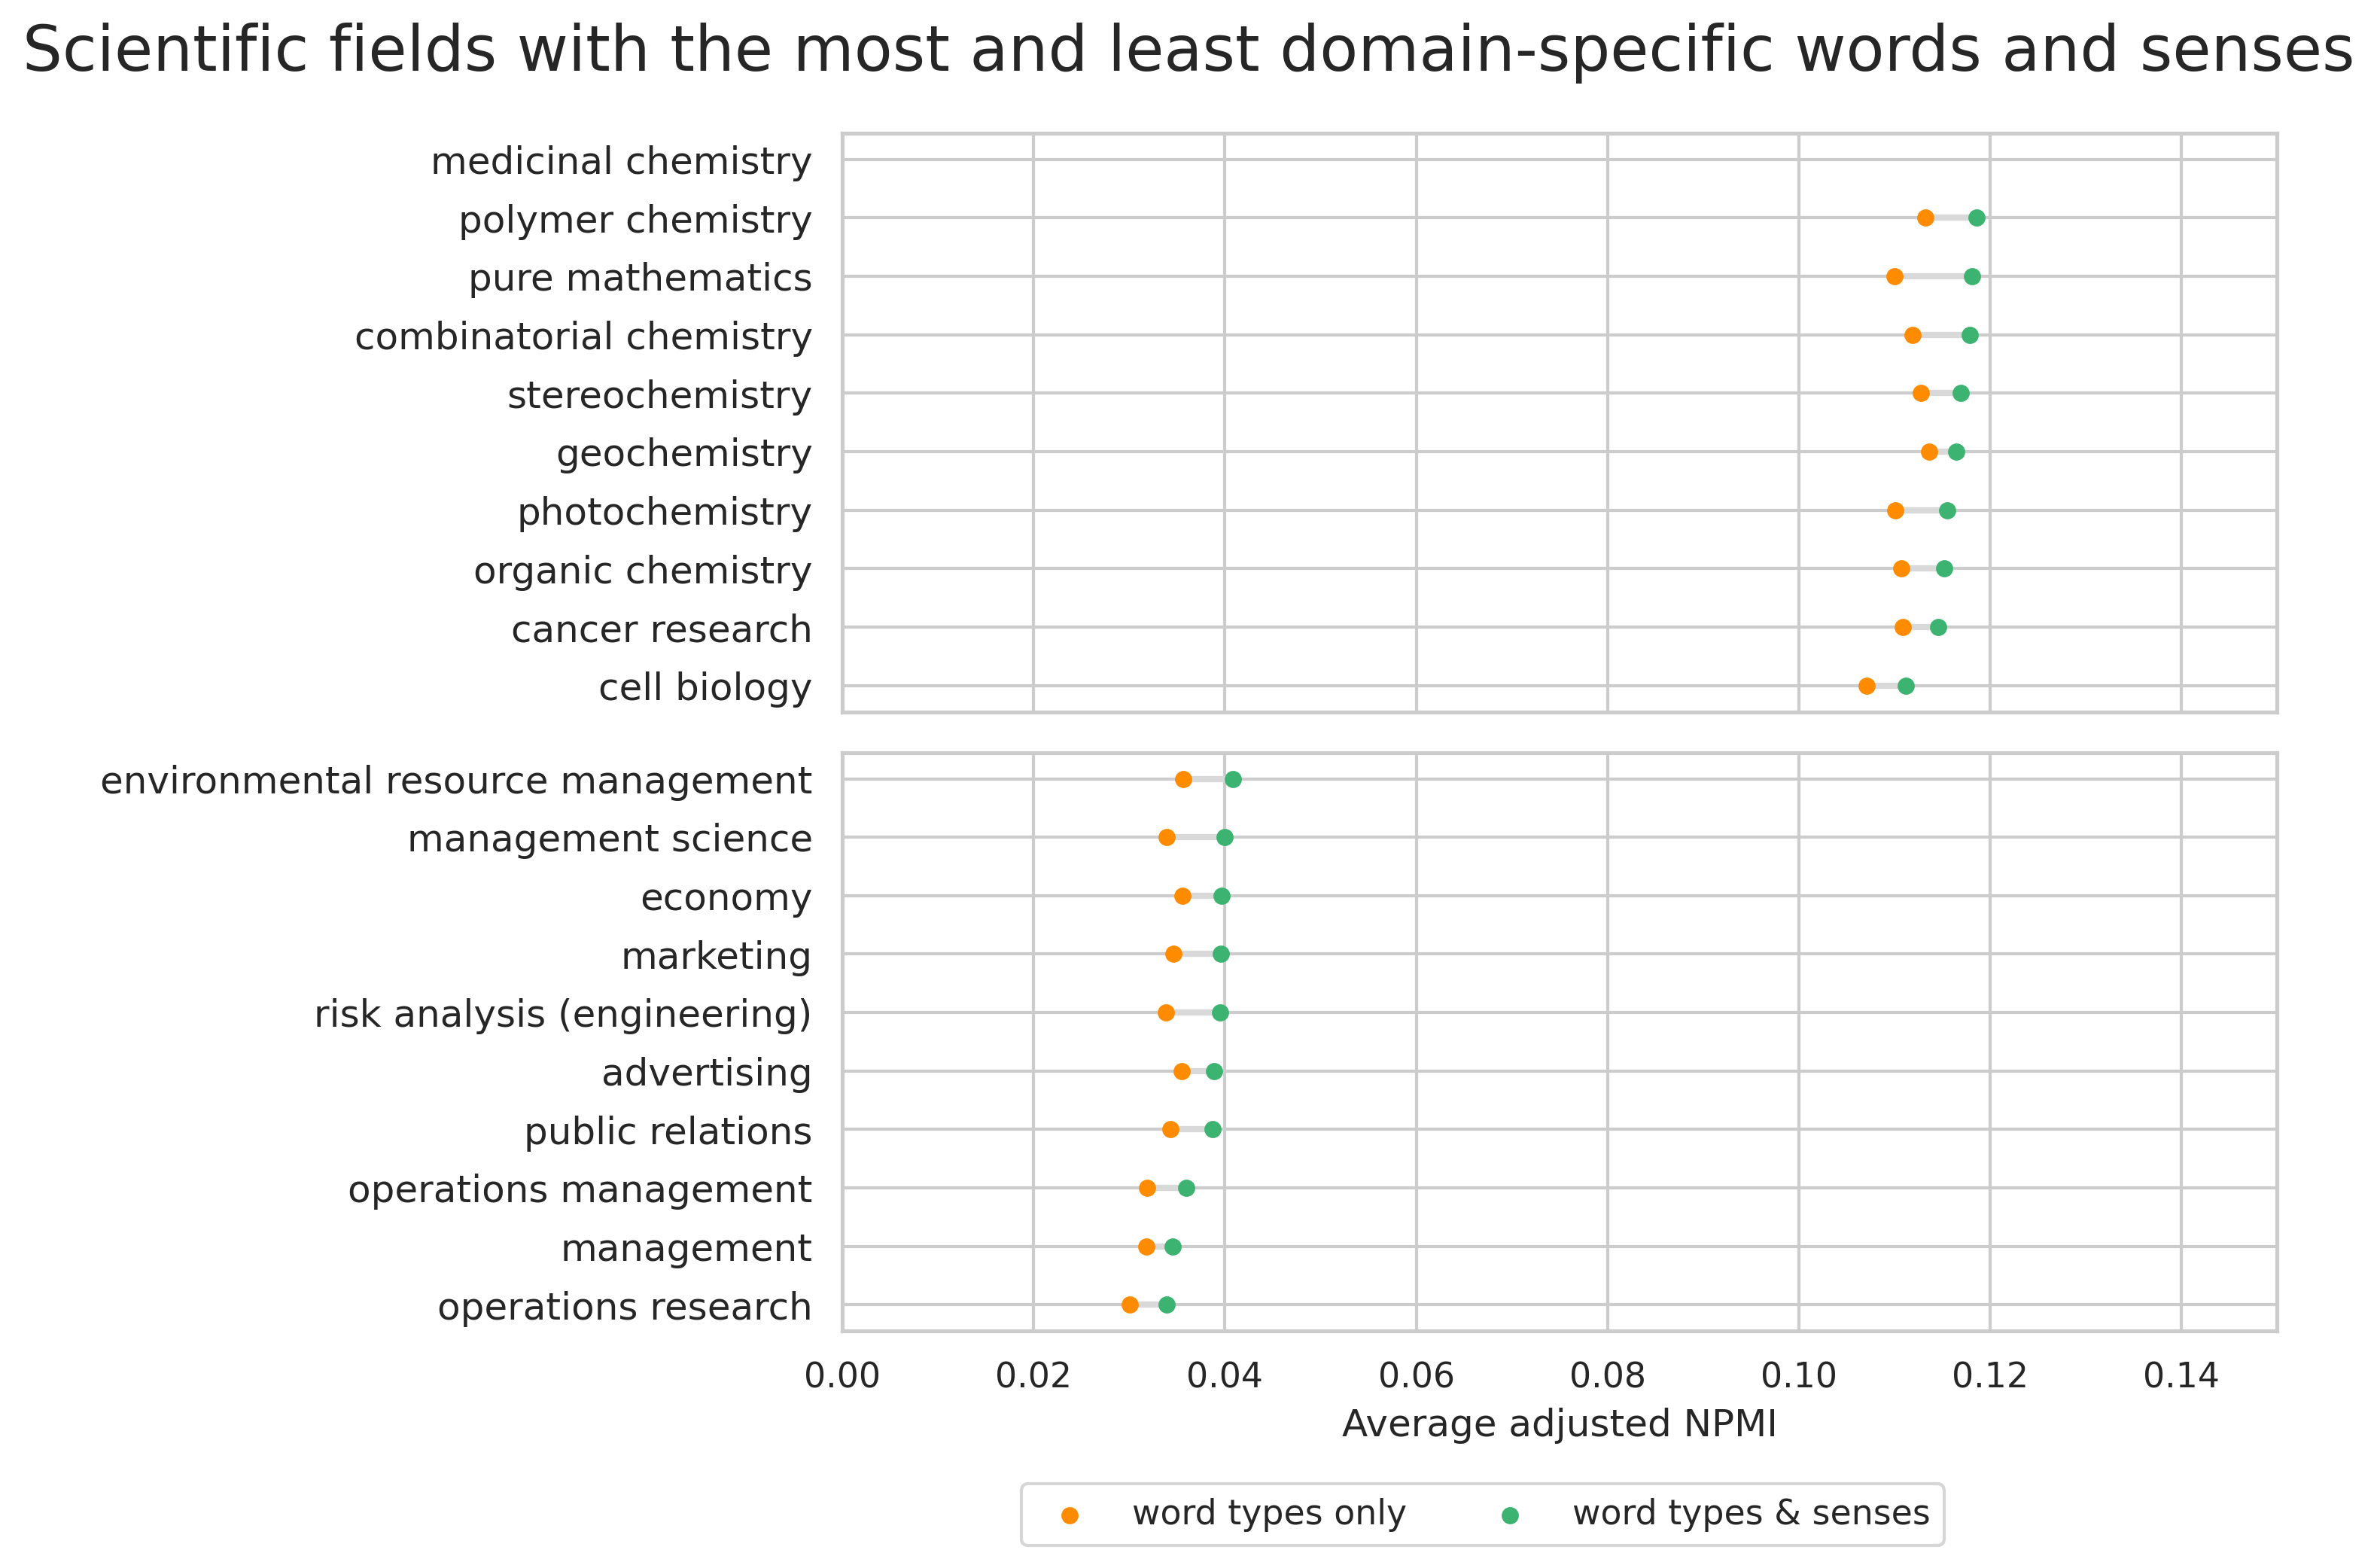

In [26]:
compare_jargonyness_df_subset = compare_jargonyness_df[~compare_jargonyness_df['FOS'].isin(['none', 'background'])]
compare_jargonyness_df_subset = compare_jargonyness_df_subset[compare_jargonyness_df_subset['FOS'].isin(level_to_topics['1'])]
df1 = compare_jargonyness_df_subset.set_index("FOS").sort_values("combined").tail(10)
df2 = compare_jargonyness_df_subset.set_index("FOS").sort_values("combined").head(10)
df1["change"] = df1["combined"] / df1["type only"] - 1
df2["change"] = df2["combined"] / df2["type only"] - 1
dfs = [df1, df2]

fig, axs = plt.subplots(2, 1, figsize=(10,7), sharex=True)
for i, ax in enumerate(axs): 
    df = dfs[i]
    y_range = np.arange(1, len(df.index) + 1)
    colors = np.where(df['combined'] > df['type only'], '#d9d9d9', '#d57883')
    ax.hlines(y=y_range, xmin=df['type only'], xmax=df['combined'],
               color=colors, lw=2)
    ax.scatter(df['type only'], y_range, c='darkorange', s=20, label='word types only', zorder=3)
    ax.scatter(df['combined'], y_range, c='mediumseagreen', s=20, label='word types & senses', zorder=3)
    ax.set_yticks(y_range, df.index, fontsize=12)
    ax.set_xlim(0, 0.15)
plt.legend(ncol=2, bbox_to_anchor=(0.78, -0.4), loc="lower right")
plt.suptitle("Scientific fields with the most and least domain-specific words and senses", fontsize=20)
plt.xlabel("Average adjusted NPMI")
plt.gcf().subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()

## Type vs. sense plot

-0.018217085399813024 0.7443041426525303


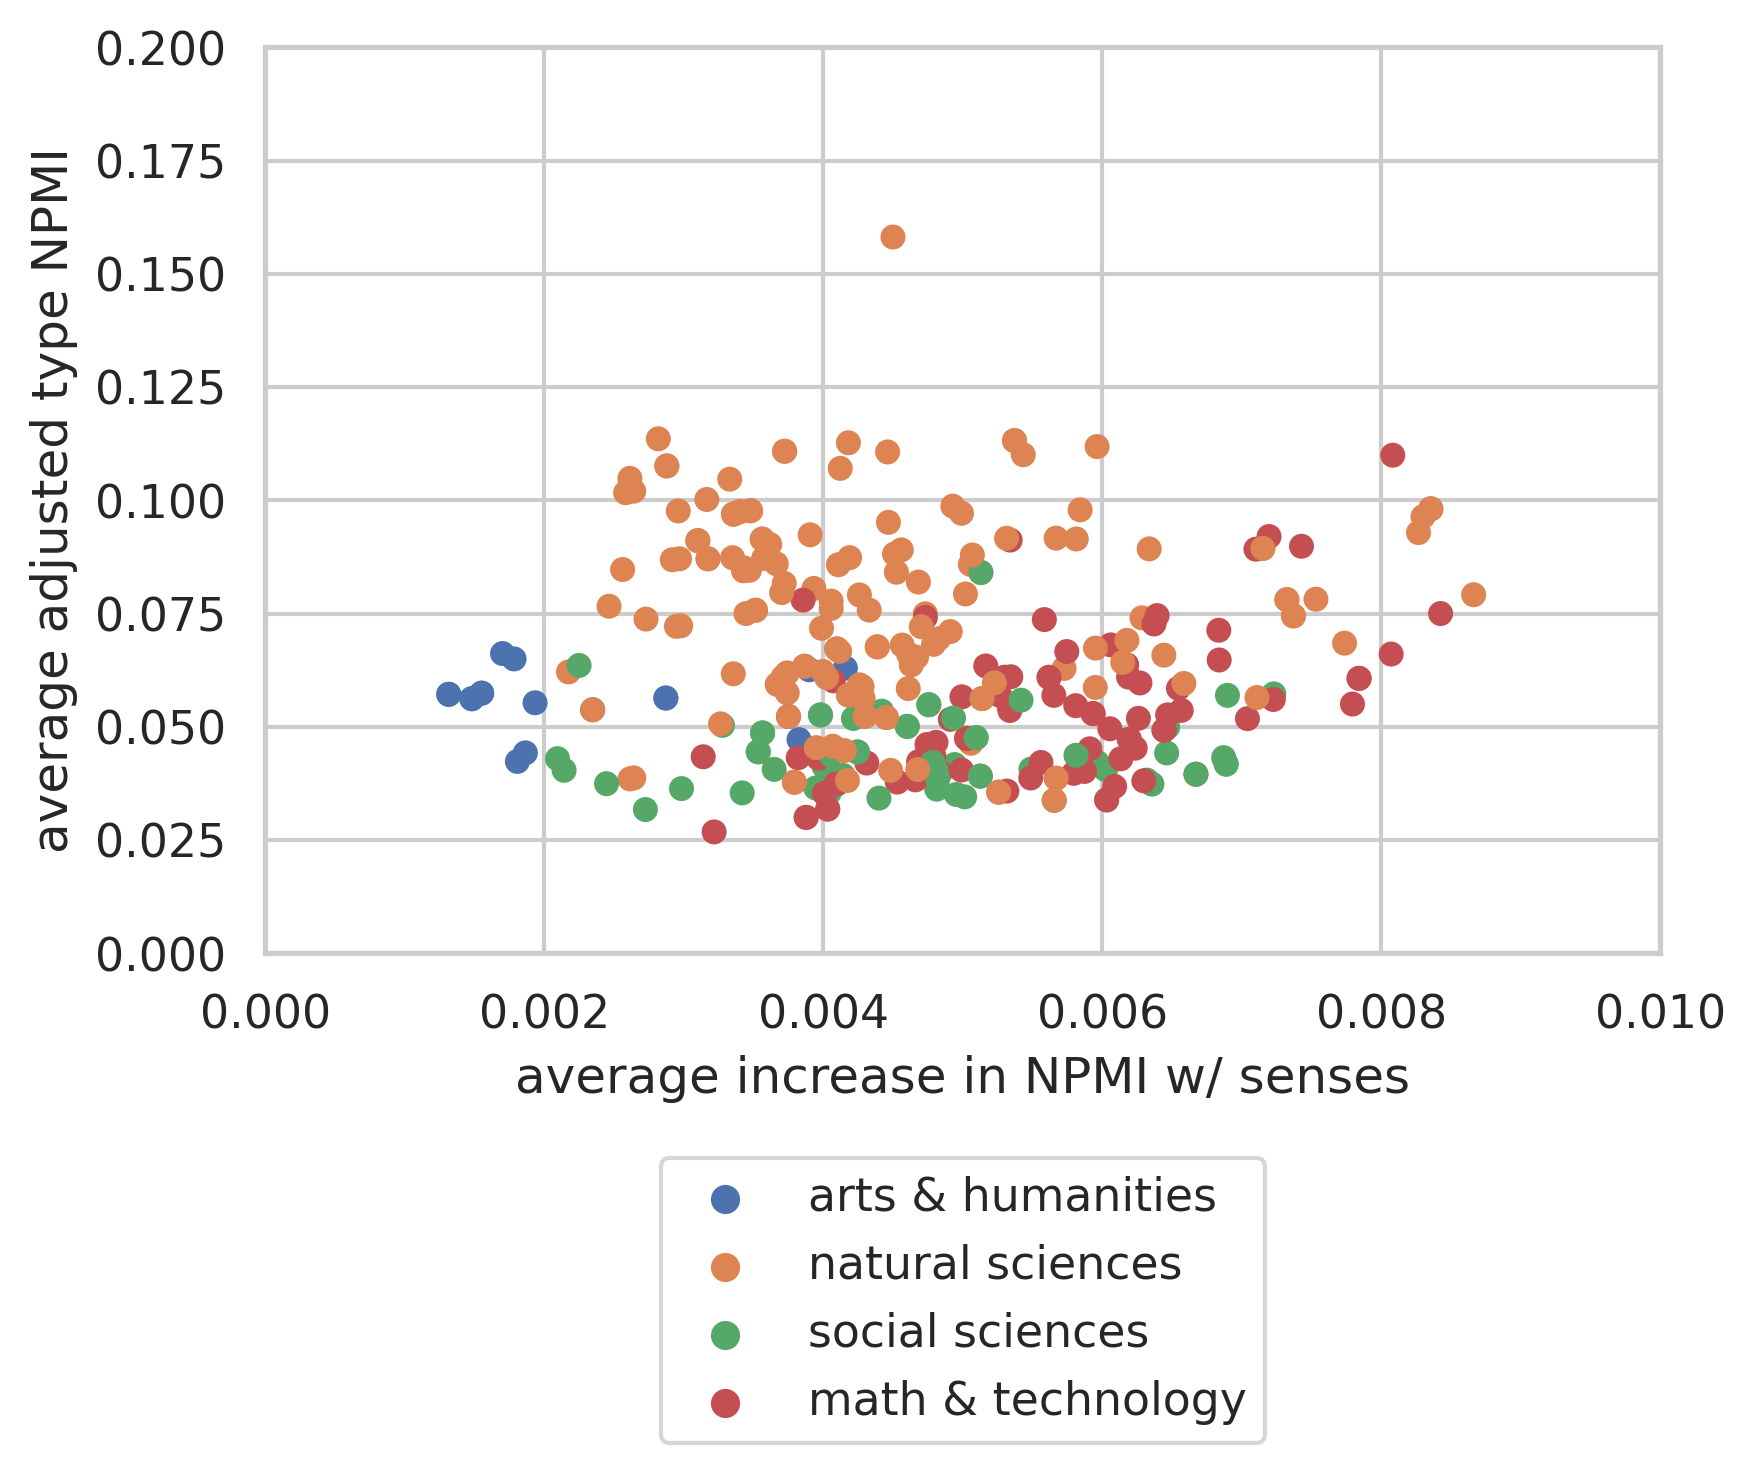

In [144]:
d = {
    'average adjusted type NPMI': [],
    'average increase in NPMI w/ senses': [],
    'label': [], 
    'field group': []
}
# map to six categories: math, physical sciences, life sciences, engineering/CS, humanities/art, social sciences
for parent in level_to_children: 
    children = level_to_children[parent]
    children.add('OTHER ' + parent)
    for child in children: 
        if child in type_sense_diff_agg: 
            d['label'].append(child)
            d['average adjusted type NPMI'].append(fos_avg_type[child])
            d['average increase in NPMI w/ senses'].append(type_sense_diff_agg[child])
            d['field group'].append(field_mapping[parent])
r, p = stats.pearsonr(x=d['average adjusted type NPMI'], y=d['average increase in NPMI w/ senses'])
print(r, p)
sns.scatterplot(data=d, x="average increase in NPMI w/ senses", y="average adjusted type NPMI",
               hue='field group', edgecolor="none")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.xlim(0, 0.01)
plt.ylim(0, 0.2)
plt.show()

In [54]:
def plot_sense_type_together(type_sense_diff_agg, fos_avg_type): 
    d = {
        'top level FOS': [],
        'current FOS': [], 
        'average adjusted type NPMI': [],
        'average increase in adjusted NPMI w/ senses': [],
        'type of FOS': [],
    }

    top_level_scores = defaultdict(list)
    for parent in level_to_children: 
        children = level_to_children[parent]
        children.add('OTHER ' + parent)
        for child in children: 
            if child in type_sense_diff_agg: 
                d['top level FOS'].append(parent.replace('science', 'sci.'))
                d['current FOS'].append(child)
                d['average adjusted type NPMI'].append(fos_avg_type[child])
                d['average increase in adjusted NPMI w/ senses'].append(type_sense_diff_agg[child])
                d['type of FOS'].append(field_mapping[parent])
                top_level_scores[parent].append(fos_avg_type[child])

    top_level_avg = Counter()
    for parent in top_level_scores: 
        top_level_avg[parent] = np.mean(top_level_scores[parent])
    order = []
    for tup in top_level_avg.most_common(): 
        order.append(tup[0].replace('science', 'sci.'))

    FOS_type_df = pd.DataFrame.from_dict(d)
    
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5.5), dpi=300)

    sns.stripplot(data=FOS_type_df, x='average adjusted type NPMI', 
                  y='top level FOS', hue='type of FOS', order=order, ax=axes[0], 
                  palette=sns.color_palette("colorblind"))
    axes[0].set_xlabel("Avg adjusted\ntype NPMI", fontsize=20)
    axes[0].set_ylabel("Field", fontsize=20)
    axes[0].set_xlim(0, 0.17)
    axes[0].set_title("Types", fontsize=20)
    axes[0].legend().remove()
    axes[0].tick_params(axis='both', which='major', labelsize=15)
    
    sns.stripplot(data=FOS_type_df, x='average increase in adjusted NPMI w/ senses', 
                  y='top level FOS', hue='type of FOS', order=order, ax=axes[1], 
                  palette=sns.color_palette("colorblind"))
    axes[1].set_xlabel("Increase in avg\nadjusted NPMI", fontsize=20)
    axes[1].set_ylabel("")
    axes[1].set_xlim(0, 0.01)
    axes[1].set_title("Senses", fontsize=20)
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend().remove()
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[1].tick_params(axis='both', which='major', labelsize=15)
    fig.legend(loc='upper center', handles=handles, fontsize=20,
               labels=labels, bbox_to_anchor=(0.6, 0), ncol=2)
    plt.tight_layout()
    plt.show()

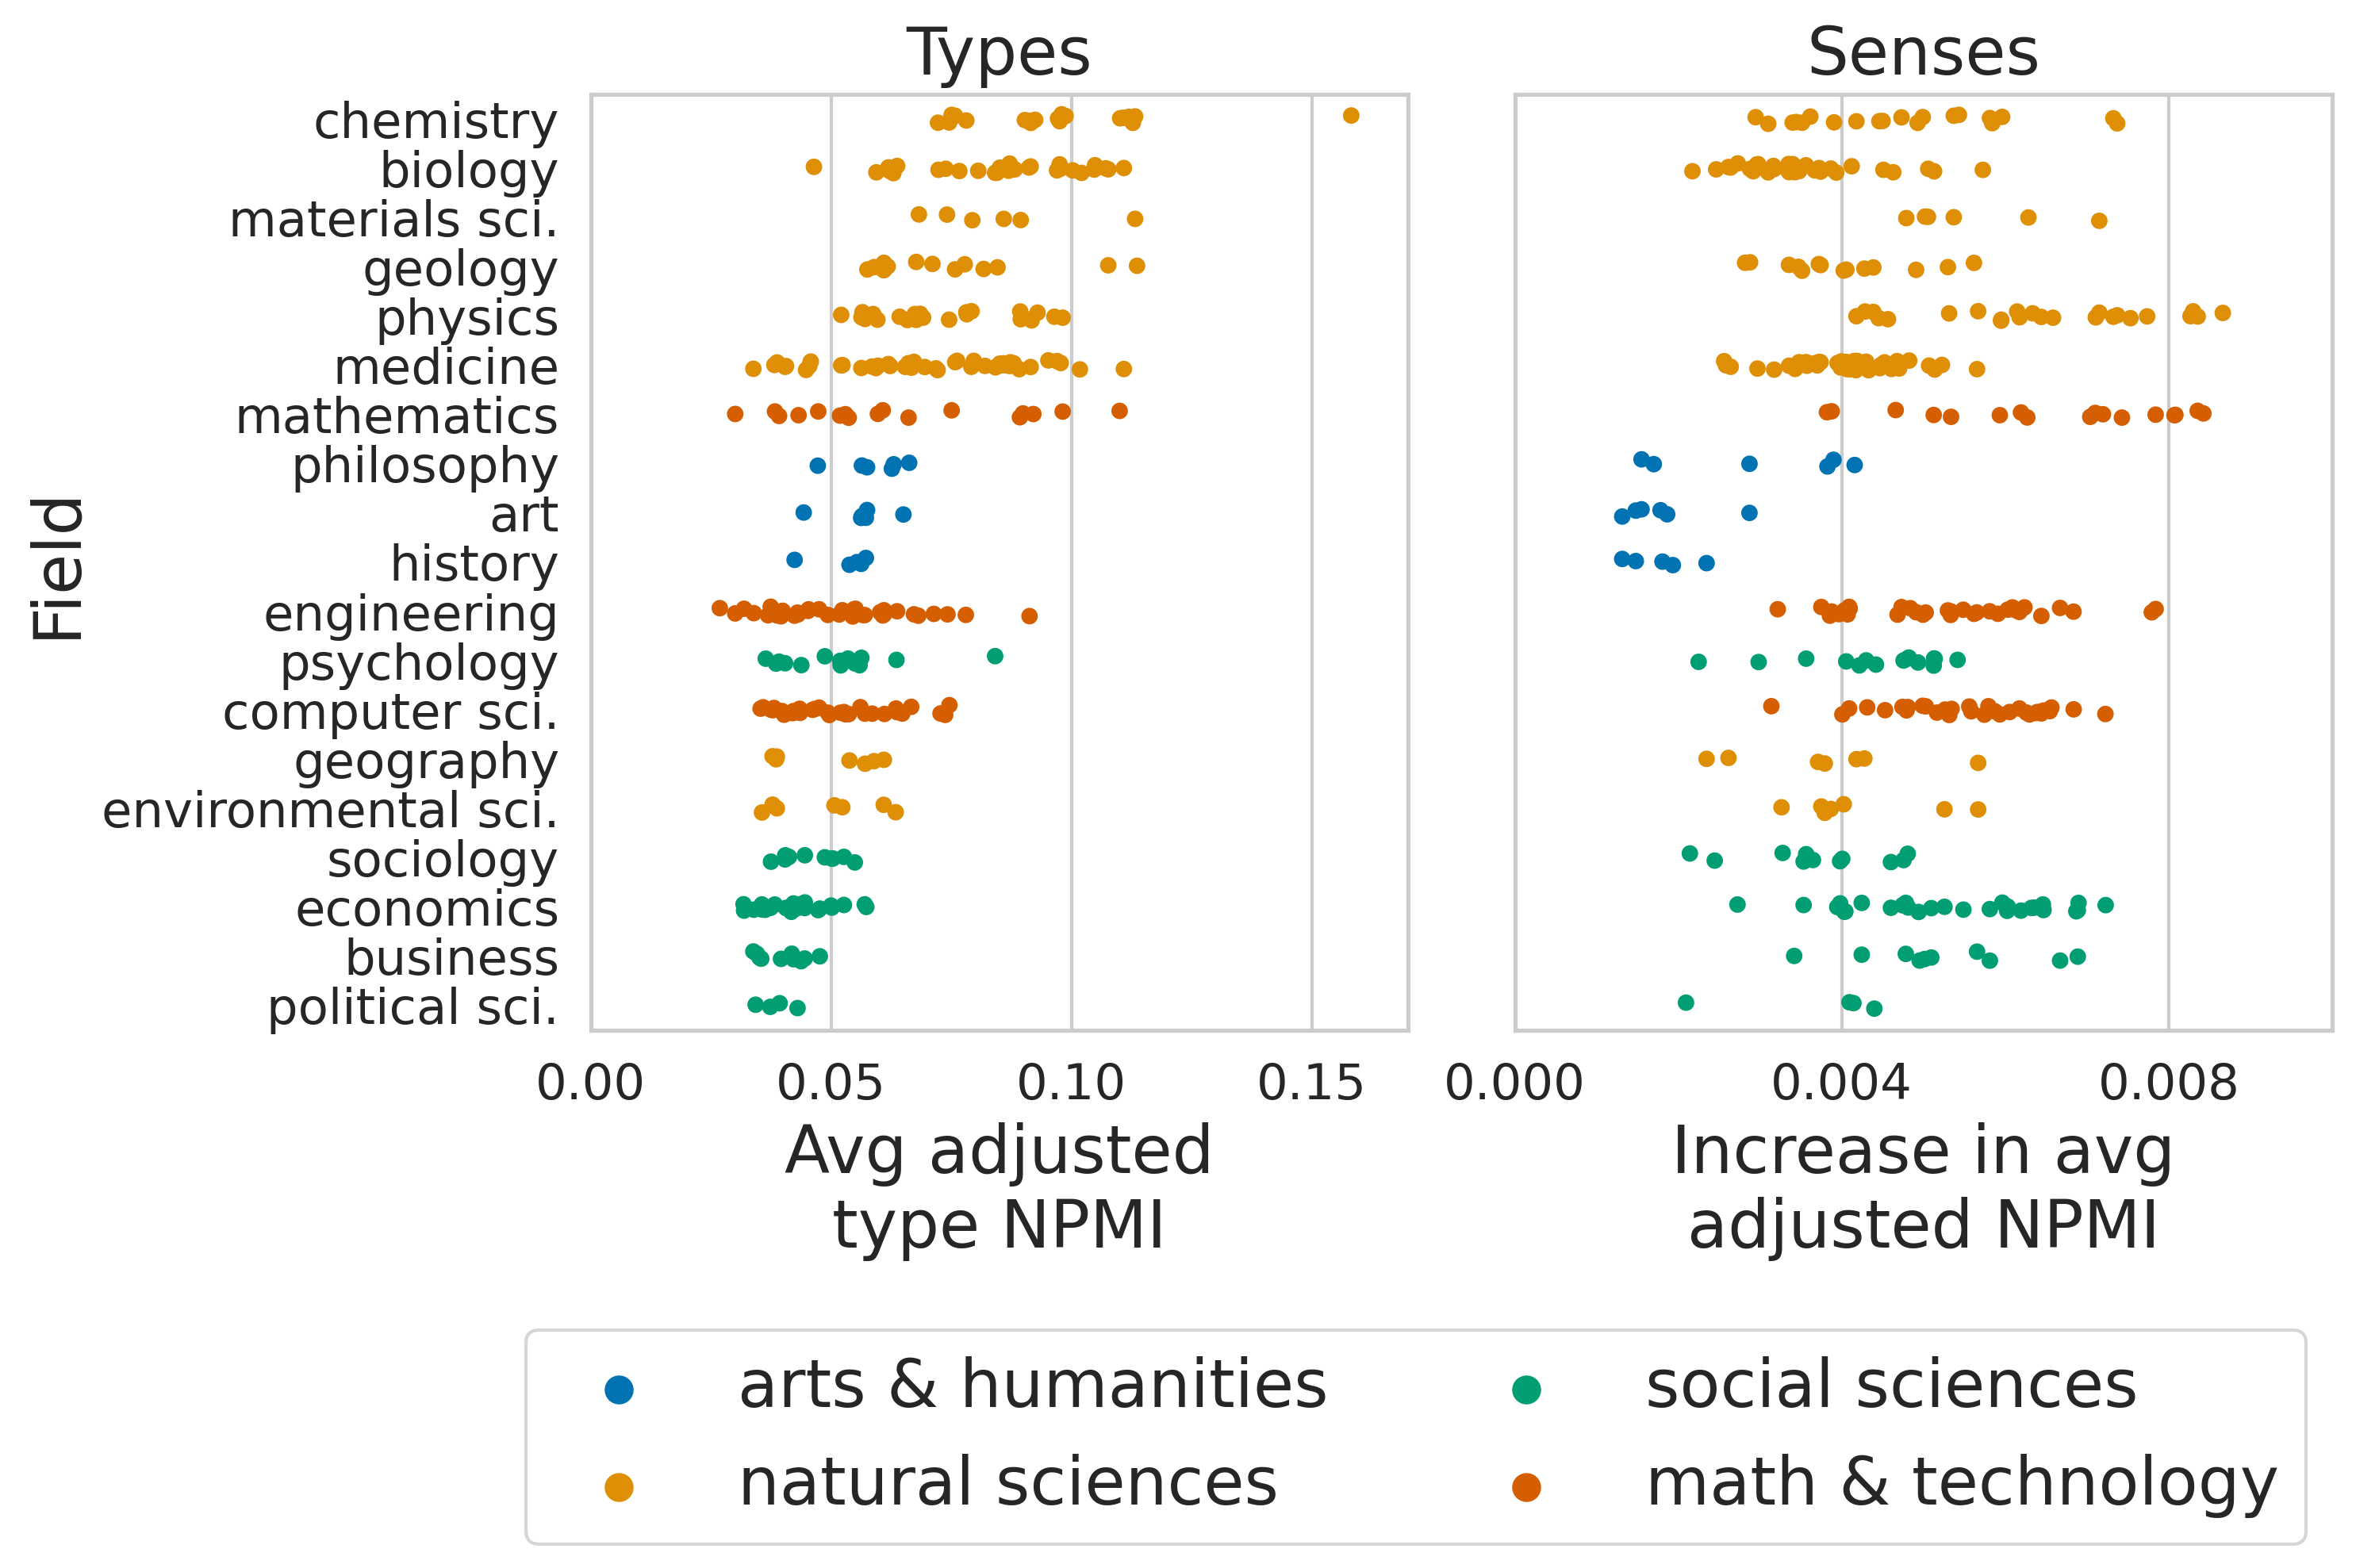

In [55]:
plot_sense_type_together(type_sense_diff_agg, fos_avg_type)

### Overloaded words table

In [53]:
words_of_interest = ['kernel', 'performance', 
                     'network', 'cost', 'power', 
                     'code', 'probability', 'rank', 'bias', 'weight', 'root', 'title']
for word in words_of_interest: 
    # get most common sense for each word and fos
    idx = fos_sense_df.groupby(['fos', 'word'])['count'].transform(max) == fos_sense_df['count']
    most_fos_sense_df = fos_sense_df[idx]
    idx = most_fos_sense_df.groupby(['word_sense'])['npmi'].transform(max) == most_fos_sense_df['npmi']
    most_fos_sense_df = most_fos_sense_df[idx]
    print(most_fos_sense_df[most_fos_sense_df['word'] == word].nlargest(20, 'npmi'))

                           fos word_sense      npmi  count    word sense
2984791       operating system   kernel_1  0.320712   3413  kernel     1
4505341               agronomy   kernel_0  0.272482   1308  kernel     0
4668226  mathematical analysis   kernel_3  0.260680    577  kernel     3
4176228  computational physics   kernel_6  0.108696     92  kernel     6
3745211           epistemology   kernel_7  0.101392     36  kernel     7
                             fos      word_sense      npmi  count  \
3752977           chromatography   performance_5  0.265717   4372   
1443902  industrial organization   performance_8  0.233858   7752   
2398570   electronic engineering   performance_4  0.201021   7976   
5901596       parallel computing   performance_3  0.192040  12528   
1782122      control engineering   performance_2  0.182616   6985   
737201                aesthetics  performance_13  0.147324   1183   
5138615                 oncology   performance_9  0.096924   1284   
397470    